In [4]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
    
import os, sys, glob
import json
import re
import numpy as np
import pandas as pd
from natsort import natsorted

import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.colors as clr

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')

from config import *
# import nlp_utils as nlp
from tommy_utils import nlp
from preproc_utils import load_model_results, divide_nwp_dataframe
import plotting_utils as utils

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


2024-10-28 15:27:43.780111: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 15:27:43.780211: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 15:27:43.780264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 15:27:43.793031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 15:27:50.122383: W tensorflow/compiler/

KeyboardInterrupt: 

In [6]:
import torchaudio

tedlium_data = torchaudio.datasets.TEDLIUM(root=CACHE_DIR, release='release3', download=True)

  7%|▋         | 3.56G/50.6G [01:59<23:36, 35.6MB/s]   

In [5]:
# EXPERIMENT_NAME = 'next-word-prediction'
# EXPERIMENT_VERSION = 'pilot-multimodal-01'
task_list = ['black', 'wheretheressmoke', 'howtodraw']
# TASK = 'black'

gentle_dir = os.path.join(BASE_DIR, 'stimuli/gentle')
results_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/')
preproc_dir = os.path.join(BASE_DIR, 'stimuli/preprocessed')
prosody_dir = os.path.join(BASE_DIR, 'stimuli/prosody')

# set the directories we need
models_dir = os.path.join(BASE_DIR, 'derivatives/model-predictions')

word_model_name = 'fasttext'

## Load data for plotting

In [4]:
# something here
df_human_results = []

for task in task_list:
    task_fn = os.path.join(results_dir, f'task-{task}_group-analyzed-behavior_human-lemmatized.csv')
    df_task = pd.read_csv(task_fn)
    df_task['task'] = task

    df_human_results.append(df_task)

# concatenate into one dataframe
df_human_results = pd.concat(df_human_results).reset_index(drop=True)
df_human_results.to_csv(os.path.join(results_dir, 'all-task_group-analyzed-behavior_human-lemmatized.csv'), index=False)

# separate into dataf rames for comparison
df_audio, df_text = [df for i, df in df_human_results.groupby('modality')]

In [68]:
prosody_columns = ['stim', 'start', 'end', 'word', 'prominence', 'boundary']

df_selected = pd.read_csv(os.path.join(preproc_dir, TASK, f'{TASK}_transcript-selected.csv'))
df_prosody = pd.read_csv(os.path.join(prosody_dir, f'{TASK}.prom'), sep='\t', names=prosody_columns)

In [69]:
remove = ["sp", "br", "lg", "cg", "ls", "ns", "sl", "ig", "{sp}", "{br}", "{lg}", 
 "{cg}", "{ls}", "{ns}", "{sl}", "{ig}", "SP", "BR", "LG", "CG", "LS",
 "NS", "SL", "IG", "{SP}", "{BR}", "{LG}", "{CG}", "{LS}", "{NS}", "{SL}", "{IG}", "pause"]

df_prosody = df_prosody[~df_prosody['word'].isin(remove)].reset_index(drop=True)
df_prosody_selected = df_prosody[df_selected['NWP_Candidate']]

In [70]:
prosody_values = df_prosody_selected['prominence']
df_human_results['prosody'] = np.tile(prosody_values, 2)

In [72]:
sns.barplot(df_human_results, x='entropy_group', y='prosody')

ValueError: Could not interpret value `entropy_group` for `x`. An entry with this name does not appear in `data`.

## Functions

In [37]:
def linear_norm(x, min, max):
    return (x - min) / (max - min)

def log_odds(x):
    return np.log((x/ (1-x)))

def plot_comparison_identity(ds_a, ds_b, lim):
    # plt.switch_backend('agg')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)

    ax.plot(lim, lim, 'k--')
    ax.scatter(ds_a, ds_b, s=10, linewidth=0, alpha=0.3)
    ax.set_xlim(lim)
    ax.set_ylim(lim)

    return fig

def create_spoken_written_cmap(continuous=True):

    if continuous:
        spoken_written_cmap = clr.LinearSegmentedColormap.from_list('spoken-written', ['#005208', '#72D16B', '#808080', '#E4B266', '#623800'], N=256)
        spoken_written_cmap = spoken_written_cmap.reversed()
    else:
        spoken_written_cmap = sns.color_palette('BuPu', n_colors=9)
        spoken_written_cmap.insert(0, '#82C564')
        spoken_written_cmap.insert(1, '#F7CD84')
    return spoken_written_cmap

def get_ordered_accuracy(df_human_models, word_model_name='fasttext'):
    
    # Get order of models by binary accuracy
    ordered_accuracy = df_human_models.loc[:,['modality', f'{word_model_name}_avg_accuracy']] \
        .groupby(['modality']) \
        .mean() \
        .sort_values(by=f'{word_model_name}_avg_accuracy').index[::-1]

    return ordered_accuracy

## Plot human results - spoken vs. written language

In [4]:
# something here
df_subject_results = []

for task in task_list:
    task_fn = os.path.join(results_dir, f'task-{task}_group-cleaned-behavior_lemmatized.csv')
    df_task = pd.read_csv(task_fn)
    df_task['task'] = task

    df_subject_results.append(df_task)

# concatenate into one dataframe
df_subject_results = pd.concat(df_subject_results).reset_index(drop=True)
df_subject_results.to_csv(os.path.join(results_dir, 'all-task_subject-behavior_lemmatized.csv'), index=False)

# # separate into dataf rames for comparison
# df_audio, df_text = [df for i, df in df_human_results.groupby('modality')]

In [9]:
df_subject_accuracy = df_subject_results.groupby(['task', 'modality', 'subject'])['accuracy'].mean().reset_index()

,task,modality,subject,accuracy
0,black,audio,sub-00001,0.204082
1,black,audio,sub-00002,0.326531
2,black,audio,sub-00003,0.541667
3,black,audio,sub-00004,0.437500
4,black,audio,sub-00005,0.408163
...,...,...,...,...
995,wheretheressmoke,text,sub-00146,0.177215
996,wheretheressmoke,text,sub-00147,0.227848
997,wheretheressmoke,text,sub-00148,0.189873
998,wheretheressmoke,text,sub-00149,0.240506


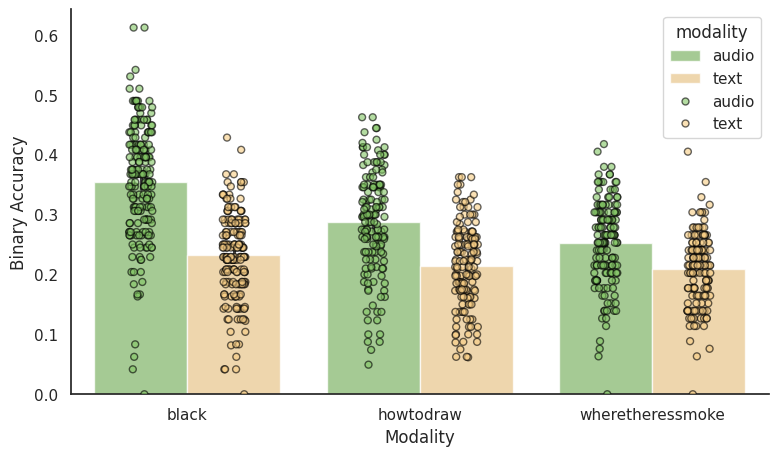

In [48]:
sns.set(style='white', rc={'figure.figsize':(9,5)})

variable = 'accuracy'

cmap = create_spoken_written_cmap(continuous=False)

ax = sns.barplot(data=df_subject_accuracy, x='task', y=variable, hue='modality', 
                palette=cmap, alpha=0.75) #, kwargs=dict(alpha=0.5))
ax = sns.stripplot(data=df_subject_accuracy, x='task', y='accuracy',  
                hue='modality', palette=cmap, size=5, edgecolor='black', 
                linewidth=1,  dodge=True, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Binary Accuracy')
# plt.title(f'Task {TASK} - binary accuracy')
# plt.ylim(0, 0.4)

sns.despine()

### Plot 01 - Binary accuracy (spoken vs. written)

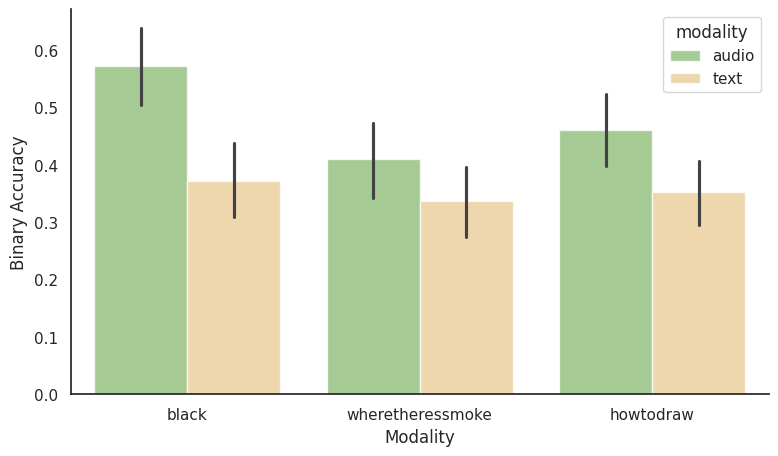

In [6]:
sns.set(style='white', rc={'figure.figsize':(9,5)})

variable = 'accuracy'

cmap = create_spoken_written_cmap(continuous=False)

ax = sns.barplot(data=df_human_results, x='task', y=variable, hue='modality', 
                 palette=cmap, alpha=0.75) #, kwargs=dict(alpha=0.5))
# ax = sns.stripplot(data=df_human_results, x='modality', y='binary_accuracy',  hue='modality', palette=cmap, size=5, edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Binary Accuracy')
# plt.title(f'Task {TASK} - binary accuracy')
# plt.ylim(0, 0.4)

sns.despine()

### Plot 02 - Continuous accuracy (spoken vs. written)

TtestResult(statistic=7.142577954921803, pvalue=2.391048650820124e-12, df=671)

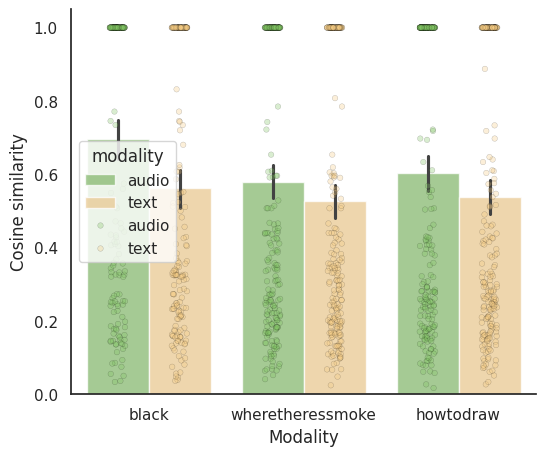

In [54]:
sns.set(style='white', rc={'figure.figsize':(6,5)})

# df_human_results['weighted_accuracy'] = df_human_results['top_prob'] * df_human_results[f'{word_model_name}_top_word_accuracy']
# variable= 'weighted_accuracy'

variable= f'{word_model_name}_top_word_accuracy'

cmap = create_spoken_written_cmap(continuous=False)

ax = sns.barplot(data=df_human_results, x='task', y=variable, hue='modality', 
                 palette=cmap, alpha=0.75) 

ax = sns.stripplot(data=df_human_results, x='task', y=variable,  hue='modality', 
                   palette=cmap, size=4, edgecolor='black', linewidth=0.25, dodge=True,
                   alpha=0.3, ax=ax)

plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
# plt.title(f'Task {TASK} - continuous accuracy')
# plt.ylim(0, 0.4)

sns.despine()

stats.ttest_rel(df_audio[variable], df_text[variable])

TtestResult(statistic=6.9807456100684036, pvalue=7.070769793241948e-12, df=671)

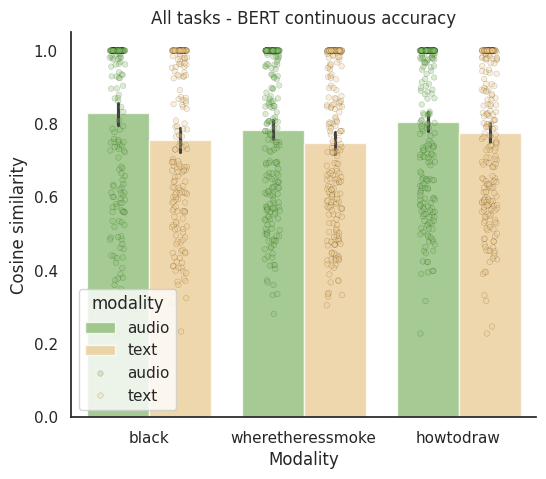

In [281]:
sns.set(style='white', rc={'figure.figsize':(6,5)})

variable = f'bert_top_word_accuracy'

cmap = create_spoken_written_cmap(continuous=False)

ax = sns.barplot(data=df_human_results, x='task', y=variable, hue='modality', 
                 palette=cmap, alpha=0.75) 

ax = sns.stripplot(data=df_human_results, x='task', y=variable,  hue='modality', 
                   palette=cmap, size=4, edgecolor='black', linewidth=0.25, dodge=True,
                   alpha=0.3, ax=ax)

plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.title(f'All tasks - BERT continuous accuracy')
# plt.ylim(0, 0.4)

sns.despine()

stats.ttest_rel(df_audio[variable], df_text[variable])

### Plot 03 - Variability of human response probabilities 

TtestResult(statistic=-5.356285048833265, pvalue=1.1685241119855816e-07, df=671)

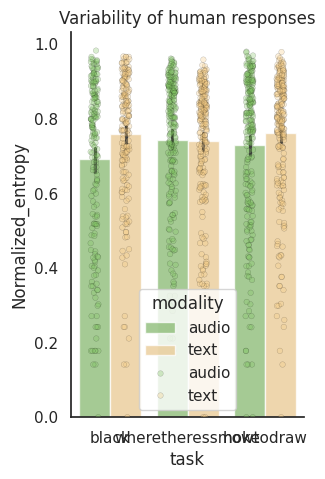

In [10]:
sns.set(style='white', rc={'figure.figsize':(3,5)})

variable = f'normalized_entropy'

cmap = create_spoken_written_cmap(continuous=False)

ax = sns.barplot(data=df_human_results, x='task', y=variable, hue='modality', palette=cmap, alpha=0.75)

ax = sns.stripplot(data=df_human_results, x='task', y=variable, hue='modality', palette=cmap, 
                   size=4, edgecolor='black', linewidth=0.25, alpha=0.3, dodge=True, ax=ax)

plt.ylabel(variable.capitalize())
plt.title('Variability of human responses')
sns.despine()

stats.ttest_rel(df_audio[variable], df_text[variable])

# plt.savefig("human_response_variability.pdf", bbox_inches='tight', dpi=300)

### Plot 04 - Predictability

TtestResult(statistic=4.668224989123951, pvalue=3.6698517568122717e-06, df=671)

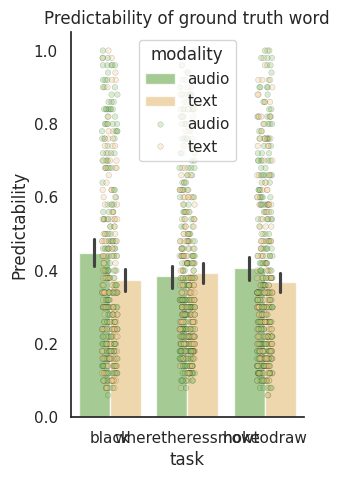

In [11]:
sns.set(style='white', rc={'figure.figsize':(3,5)})
cmap = create_spoken_written_cmap(continuous=False)

variable = 'top_prob'

ax = sns.barplot(data=df_human_results, x='task', y=variable, hue='modality', palette=cmap, alpha=0.75)

ax = sns.stripplot(data=df_human_results,  x='task', y=variable, hue='modality', palette=cmap, 
                   size=4, edgecolor='black', linewidth=0.25, alpha=0.3, ax=ax)

plt.ylabel('Predictability')
plt.title('Predictability of ground truth word')
sns.despine()

stats.ttest_rel(df_audio[variable], df_text[variable])

# plt.savefig("human_continuous_accuracy.pdf", bbox_inches='tight', dpi=300)

### Plot 05 - Predictability of ground truth word

In [7]:
df_predictability = pd.pivot(df_human_results, index=['task', 'word_index'], columns='modality', values='predictability')
# df_modality_accuracy = pd.pivot(df_human_results, index='word_index', columns='modality', values=f'fasttext_top_word_accuracy')

# colors = df_predictability['audio'] - df_predictability['text']
# colors = linear_norm(colors.to_numpy(), -1, 1)

df_predictability['colors'] = colors



0.718441593386597 4.109641349080519e-147


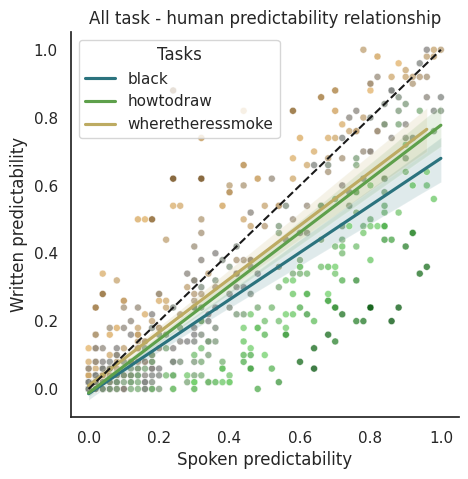

In [55]:
cmap = create_spoken_written_cmap()
sns.set(style='white', rc={'figure.figsize':(5,5)})

line_cmap = sns.color_palette("gist_earth", 3)

fig, ax = plt.subplots(1,1)

for i, (task, df) in enumerate(df_predictability.groupby('task')):

    # lines of color to average skew = cmap(df['colors'].mean())
    avg_color = cmap(df['colors'].mean())

    ax = sns.scatterplot(data=df, x='audio', y='text', hue='colors', palette=cmap, alpha=0.75, s=25, ax=ax, legend=False)
    ax = sns.regplot(data=df, x='audio', y='text', color=line_cmap[i], scatter=False, label=task, ax=ax)

plt.plot((0,1), (0, 1), 'k--')
r, pval = kendalltau(df_predictability['audio'], df_predictability['text'])
print (r, pval)

# ax.get_legend().remove()

# Add custom legend for regression lines
# ax.legend(legend_lines, legend_labels, title='Tasks', loc='best')
# Add legend for regression lines
plt.legend(title='Tasks')

plt.ylabel('Written predictability')
plt.xlabel('Spoken predictability') 

plt.title(f'All task - human predictability relationship')
sns.despine()
# plt.savefig("human_predictability.pdf", bbox_inches='tight', dpi=300)

## Plot human vs. LLM results

### Load data for plotting

In [7]:
# something here
df_human_models = []
window_size = 25

for task in task_list:
    compiled_results_fn = os.path.join(results_dir, f'task-{task}_group-analyzed-behavior_window-size-{window_size}_human-model-lemmatized.csv')
    df = pd.read_csv(compiled_results_fn)
    df['task'] = task
    df_human_models.append(df)

df_human_models = pd.concat(df_human_models).reset_index(drop=True)
# # make a new dataframe and drop missing values --> this is specifically for stats
# df_anova = df_human_models.copy()
# df_anova = df_anova[~df_anova[f'{word_model_name}_avg_accuracy'].isna()]

### Set model names and display order

In [7]:
# get all MLM models except BERT
MLM_MODELS = list(nlp.MLM_MODELS_DICT.keys())[1:]
CLM_MODELS = list(nlp.CLM_MODELS_DICT.keys()) 
model_names = CLM_MODELS + MLM_MODELS

print (f'Loading the following models')
print (f'MLM models: {MLM_MODELS}')
print (f'CLM models: {CLM_MODELS}')

ordered_accuracy = utils.get_ordered_accuracy(df_human_models)

# now order the models and conditions for plotting
human_conditions = ['audio', 'text']
ordered_models = [item for item in ordered_accuracy if item not in ['audio', 'text', *MLM_MODELS]]
ordered_modalities = human_conditions + ordered_models + MLM_MODELS
ordered_conditions = ['low-high', 'high-high', 'low-low', 'high-low']

Loading the following models
MLM models: ['roberta', 'electra', 'xlm-prophetnet']
CLM models: ['bloom', 'gpt2', 'gpt2-xl', 'gpt-neo-x', 'llama2', 'mistral']


### Plot 01 - Binary accuracy

In [1]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
axes = axes.flatten()

variable = f'fasttext_avg_accuracy'

for ax, (task, df) in zip(axes, df_human_models.groupby('task')):

    plt.sca(ax)
    ax = plot_bar_results(df, x='modality', y=variable, hue=None, cmap=cmap, figsize=None, add_points=False, order=ordered_modalities, add_points=True)
    ax.set_ylim([0, 1])
    ax.set_title(f'Task - {task}')
    plt.xticks(rotation=45, ha='right')

NameError: name 'plt' is not defined

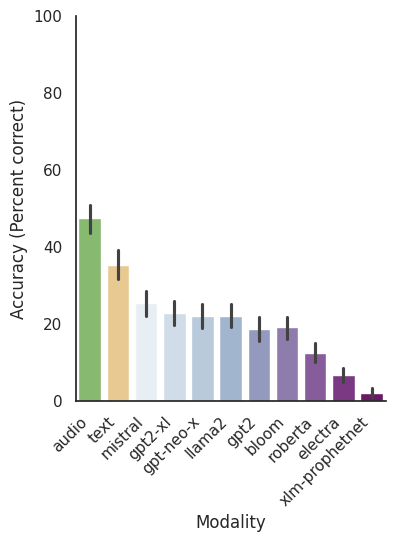

In [29]:
cmap = create_spoken_written_cmap(continuous=False)
sns.set(style='white', rc={'figure.figsize':(4,5), "axes.titlesize":18}, font_scale=1)

variable = 'accuracy'

ax = sns.barplot(data=df_human_models, x='modality', y=variable, palette=cmap, order=ordered_modalities) #, alpha=0.75) #, kwargs=dict(alpha=0.5))
# ax = sns.stripplot(data=human_model_combined, x='modality', y='accuracy',  hue='modality', palette='BuPu', size=5, edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Accuracy (Percent correct)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

sns.despine()
# plt.savefig("binary_accuracy.pdf", bbox_inches='tight', dpi=600)

### Plot 02 - Continuous accuracy

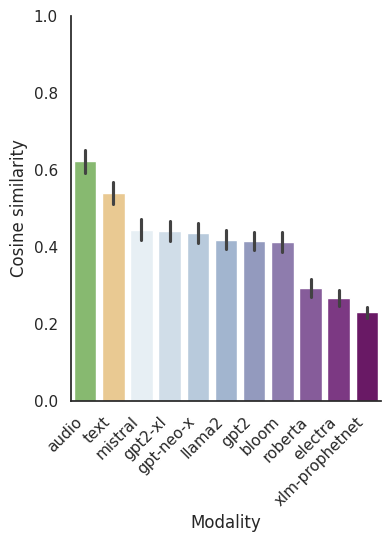

In [30]:
cmap = create_spoken_written_cmap(continuous=False)
sns.set(style='white', rc={'figure.figsize':(4,5), "axes.titlesize":18}, font_scale=1)

variable = 'fasttext_avg_accuracy'

ax = sns.barplot(data=df_human_models, x='modality', y=variable, palette=cmap, order=ordered_modalities) #, alpha=0.75) #, kwargs=dict(alpha=0.5))
# ax = sns.stripplot(data=human_model_combined, x='modality', y='accuracy',  hue='modality', palette='BuPu', size=5, edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

sns.despine()
# plt.savefig("binary_accuracy.pdf", bbox_inches='tight', dpi=600)

#### Statistics

In [73]:
variable = f'{word_model_name}_avg_accuracy'

model = ols(f'{variable} ~ modality', data=df_anova).fit() #df_anova.dropna()).fit()
anova_table = sm.stats.anova_lm(model, typ=3)

print (anova_table)

# human_model_combined = human_model_combined.dropna()

hs_res=pairwise_tukeyhsd(df_anova[variable], df_anova['modality'])
print(hs_res)

NameError: name 'df_anova' is not defined

### Plot 03 - Continuous accuracy x entropy/accuracy group 

Also contains ANOVA + pairwise tests within each entropy/accuracy quadrant

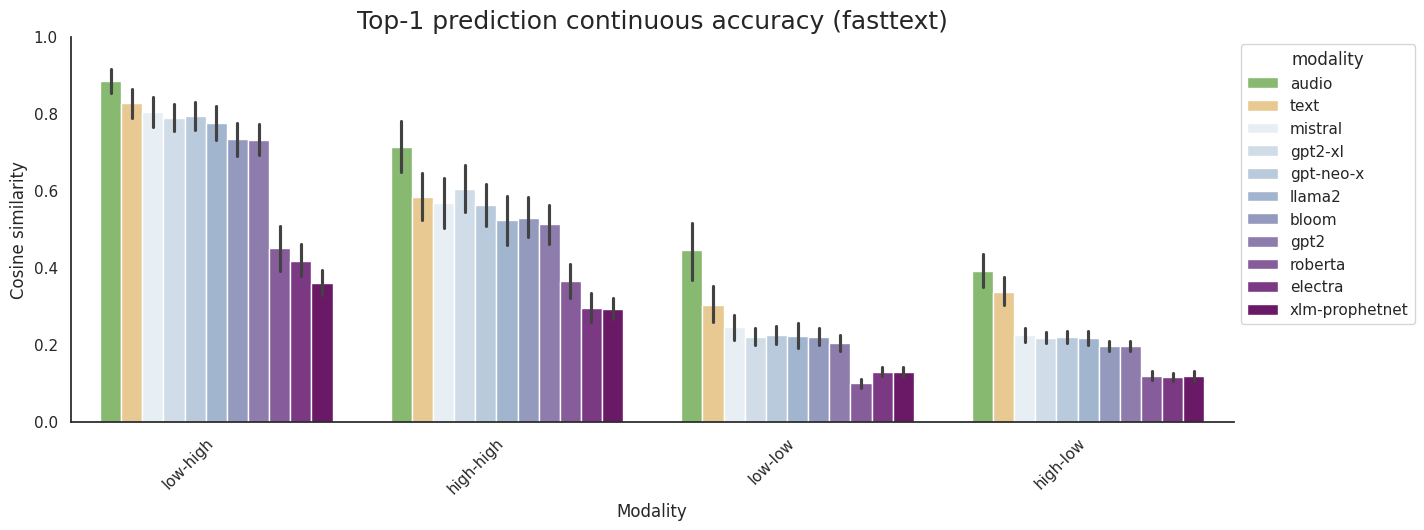

In [74]:
cmap = create_spoken_written_cmap(continuous=False)

fig, ax = plt.subplots(1,1, figsize=(15,5))

variable = f'{word_model_name}_avg_accuracy'

ax = sns.barplot(data=df_human_models, x='entropy_accuracy_group', y=variable, hue="modality",
                 palette=cmap, ax=ax, hue_order=ordered_modalities, order=ordered_conditions) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.title(f'Top-1 prediction continuous accuracy ({word_model_name})')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

sns.despine()
# plt.savefig("prediction_accuracy.pdf", bbox_inches='tight', dpi=600)

In [146]:
for i, df in df_anova.groupby('entropy_accuracy_group'):
    print (i)
    df = df.dropna().reset_index(drop=True)
    model = ols('fasttext_avg_accuracy ~ modality', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=3)

    print (anova_table)
# human_model_combined = human_model_combined.dropna()

    hs_res=pairwise_tukeyhsd(df["fasttext_avg_accuracy"], df['modality'])
    print(hs_res)

high-high
              sum_sq     df           F        PR(>F)
Intercept  19.034199    1.0  215.261852  2.061615e-41
modality    8.687484   10.0    9.824862  3.255694e-15
Residual   48.986601  554.0         NaN           NaN
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
    audio          bloom  -0.1422 0.3956 -0.3371  0.0527  False
    audio        electra  -0.3911    0.0 -0.5838 -0.1984   True
    audio      gpt-neo-x  -0.1623 0.2161 -0.3588  0.0341  False
    audio           gpt2  -0.1623 0.2213 -0.3596  0.0349  False
    audio        gpt2-xl  -0.0655 0.9949 -0.2728  0.1418  False
    audio         llama2  -0.2273 0.0172 -0.4334 -0.0212   True
    audio        mistral  -0.1409  0.537  -0.352  0.0703  False
    audio        roberta  -0.2451 0.0014 -0.4329 -0.0573   True
    audio           text  -0.0716 0.9898 -0.2789  0.1357  False
    au

### Plot 04 - Continuous accuracy over quadrants

In [112]:
def plot_quadrant_distributions(model_results, accuracy_type, percentile, indices=None):
    
    # get xmedian and ymedian --> needs to happen before otherwise plot is off
    x_median = np.nanmedian(model_results[accuracy_type])
    y_median = np.nanmedian(model_results['entropy'])
    
    xmin, xmax = model_results[accuracy_type].max(), model_results[accuracy_type].min()
    ymin, ymax = model_results['entropy'].max(), model_results['entropy'].min()
    
    # divide the data into quadrants based on percentile
    # we use a form of continuous accuracy and entropy
    df_divide = divide_nwp_dataframe(model_results, accuracy_type=accuracy_type, percentile=percentile, drop=False)

    if indices is not None:
        df_divide = df_divide.loc[indices]

    return df_divide
    
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    # axes = axes.flatten()
    
    ax = sns.scatterplot(data=df_divide, x=accuracy_type, y='entropy', hue='binary_accuracy', 
                     color='.6', palette="BuPu", alpha=0.75, ax=ax)
    
    # turn off top and right axes
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.vlines(x=x_median, ymin=ymin, ymax=ymax, linestyles='dashed', color='k')
    ax.hlines(y=y_median, xmin=xmin, xmax=xmax, linestyles='dashed', color='k')
    
    ax.title.set_text('Division of NWP candidates by median entropy/accuracy')
    
    return fig, ax

ValueError: aweights cannot be negative

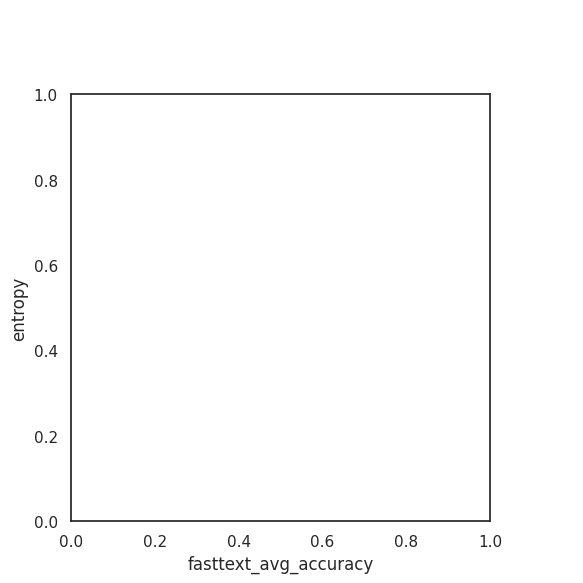

In [21]:
df_all_tasks = []

for task in task_list:
    model_quadrants = utils.load_model_quadrant_info(preproc_dir, models_dir, task=task, model_name='gpt2-xl')
    df_task = df_human_models[df_human_models['task'] == task]

    df_all_tasks.append((df_task, model_quadrants))

df_tasks, df_quadrants = [pd.concat(df).reset_index(drop=True) for df in zip(*df_all_tasks)]
utils.create_joint_density_plot(df_tasks, df_quadrants, word_model_name='fasttext', weight_type='human>model', bw_adjust=1)

In [17]:
# FOR DIVIDING THE MODEL RESULTS INTO QUADRANTS
ACCURACY_TYPE = f'{word_model_name}_avg_accuracy'
ACCURACY_PERCENTILE = 45
WINDOW_SIZE = 25
TOP_N = 5

preproc_dir = os.path.join(BASE_DIR, 'stimuli', 'preprocessed')

# load our preprocessed file --> get the indices of the prediction words
df_preproc = pd.read_csv(os.path.join(preproc_dir, TASK, f'{TASK}_transcript-preprocessed.csv'))
nwp_idxs = np.where(df_preproc['NWP_Candidate'])[0]

# select based on model quadrants --> trim down to only the words of interest
model_results = load_model_results(models_dir, model_name='gpt2-xl', task=TASK, window_size=WINDOW_SIZE, top_n=TOP_N)
model_results.loc[:, 'binary_accuracy'] = model_results['binary_accuracy'].astype(bool)
model_results = model_results.iloc[nwp_idxs]


NameError: name 'TASK' is not defined

In [122]:
modalities = ['audio', 'text']

human_model_accuracy_contrast = {}
models_only = df_human_models[~df_human_models['modality'].isin(['audio', 'text'])]
humans_only = df_human_models[df_human_models['modality'].isin(['audio', 'text'])]

audio, text = [df_human_models[df_human_models['modality'] == modality][ACCURACY_TYPE].to_numpy()[..., np.newaxis] for modality in modalities]

models_only = df_human_models[~df_human_models['modality'].isin(modalities)]
models_only = pd.pivot(models_only, index='word_index', columns='modality', values=ACCURACY_TYPE).to_numpy()

avg_model = np.nanmean(models_only, axis=1)[..., np.newaxis]

audio_v_model = audio - avg_model #np.nanmean(audio - models_only, axis=1)
text_v_model = text - avg_model # np.nanmean(text - models_only, axis=1)

In [123]:
from scipy.stats import zscore

def linear_norm(x, min, max):
    return (x - min) / (max - min)

In [124]:
# load our preprocessed file --> get the indices of the prediction words
df_selected = pd.read_csv(os.path.join(BASE_DIR, 'stimuli/preprocessed', TASK, f'{TASK}_transcript-selected.csv'))
selected_idxs = np.where(df_selected['NWP_Candidate'])[0]

# model_quadrants = get_model_word_quadrants('gpt2-xl', TASK, selected_idxs, accuracy_type=f'{word_model_name}_max_accuracy').reset_index(drop=True)
df_divide = plot_quadrant_distributions(model_results, ACCURACY_TYPE, ACCURACY_PERCENTILE, indices=selected_idxs)

min = -1 
max = 1

df_divide['audio>model'] = linear_norm(audio_v_model, min, max)
df_divide['text>model'] = linear_norm(text_v_model, min, max) #min_max_norm(np.nanmean(text - , axis=0)) 
df_divide['human>model'] = linear_norm((audio_v_model + text_v_model)/2, min, max) #, axis=0)) 
df_divide['audio>text'] = linear_norm(audio - text, min, max)

### Plot 03 - Continuous accuracy over LLM quadrants

In [6]:
# FOR DIVIDING THE MODEL RESULTS INTO QUADRANTS
ACCURACY_TYPE = f'fasttext_avg_accuracy'
ACCURACY_PERCENTILE = 45
WINDOW_SIZE = 25
TOP_N = 5

preproc_dir = os.path.join(BASE_DIR, 'stimuli', 'preprocessed')

# load our preprocessed file --> get the indices of the prediction words
df_preproc = pd.read_csv(os.path.join(preproc_dir, TASK, f'{TASK}_transcript-preprocessed.csv'))
nwp_idxs = np.where(df_preproc['NWP_Candidate'])[0]

# select based on model quadrants --> trim down to only the words of interest
model_results = load_model_results(models_dir, model_name='gpt2-xl', task=TASK, window_size=WINDOW_SIZE, top_n=TOP_N)
model_results.loc[:, 'binary_accuracy'] = model_results['binary_accuracy'].astype(bool)
model_results = model_results.iloc[nwp_idxs]


NameError: name 'os' is not defined

In [6]:
import seaborn as sns
from matplotlib import cm
sns.set_theme(style="white")

# df = sns.load_dataset("penguins")
# sns.set(style='white', rc={'figure.figsize':(6,5)})
cmap = cm.get_cmap('BuPu')

weight_type = 'human>model'
weights = df_divide[weight_type].to_numpy()
density_min = df_divide[weight_type].min()
density_max = df_divide[weight_type].max()

clip_x = (df_divide[ACCURACY_TYPE].min(), df_divide[ACCURACY_TYPE].max())
clip_y =  (df_divide["entropy"].min(), df_divide["entropy"].max())

g = sns.JointGrid(data=df_divide, x=ACCURACY_TYPE, y="entropy", space=0)


g.plot_joint(sns.scatterplot, color="k", alpha=0.75, s=30)


g.plot_joint(sns.kdeplot, weights=weights,
             bw_adjust=0.65, fill=True,
             thresh=0.65*weights.mean(), levels=100, cmap=cmap, alpha=0.5, cbar=True)

g.plot_marginals(sns.kdeplot, color=cmap(0.5), fill=True, bw_adjust=0.5) #, kde=True, alpha=1) #, bins=25)

# get xmedian and ymedian --> needs to happen before otherwise plot is off
x_median = np.nanmedian(model_results[ACCURACY_TYPE])
y_median = np.nanmedian(model_results['entropy'])

xmin, xmax = model_results[ACCURACY_TYPE].min(), model_results[ACCURACY_TYPE].max()
ymin, ymax = model_results['entropy'].min(), model_results['entropy'].max()


g.fig.axes[0].set_ylim(0, ymax)
g.fig.axes[0].set_xlim(0, xmax)

g.fig.axes[0].vlines(x=x_median, ymin=ymin, ymax=ymax, linestyles='dashed', color='.33')
g.fig.axes[0].hlines(y=y_median, xmin=xmin, xmax=xmax, linestyles='dashed', color='.33')

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)


# # get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()

# reposition the joint ax so it has the same width as the marginal x ax
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# # reposition the colorbar using new x positions and y positions of the joint ax
g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

# # get the current colorbar ticks
# cbar_ticks = g.fig.axes[-1].get_yticks()
# # # get the maximum value of the colorbar
# _, cbar_max = g.fig.axes[-1].get_ylim()

# g.fig.axes[-1]
# g.fig.axes[-1].set_yticks([i for i in range(1, 100, 10)])

# tick_locator = ticker.MaxNLocator(nbins=5)
# g.fig.axes[-1].locator = tick_locator
# g.fig.axes[-1].update_ticks()
# g.fig.axes[-1] = 

plt.ylabel('GPT2-XL Entropy')
plt.ylabel('Continuous Accuracy')

# plt.suptitle('Human accuracy improvement over model')

# cbar= plot_colorbar(vmin=difference_min, vmax=difference_max, vcenter=difference_center, nticks=6, cmap='mako', direction='vertical')
# g.fig.axes[-1].set_yticklabels([i for i in range(100)])

# # # change the labels (not the ticks themselves) to a percentage
# g.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 100:.1f} %' for t in cbar_ticks])

# plt.show()

# plt.savefig("entropy_accuracy_density.pdf", bbox_inches='tight', dpi=600)


NameError: name 'df_divide' is not defined

In [468]:
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
from matplotlib import ticker

def plot_colorbar(vmin, vmax, vcenter, nticks=5, direction='horizontal', cmap='RdBu_r', out_fn=None):
	
	fig = plt.figure()
	
	values = np.random.randn(10)
	
	divnorm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
	psm = plt.pcolormesh([-values, values], norm=divnorm, cmap=cmap)
	plt.clf()
	
	# xloc, yloc, size x, size y
	if direction == 'horizontal':
		cbar_ax = fig.add_axes([0.5, 0, 0.6, 0.05])
	elif direction == 'vertical':
		cbar_ax = fig.add_axes([0.5, 0, 0.05, 0.6])
	
	fig.colorbar(psm, cax=cbar_ax, orientation=direction, ticks=ticker.MaxNLocator(nbins=nticks))
	return fig

### Plot 05 - Continuous accuracy line plot

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/asynchrony/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/scratch/ipykernel_6855/1228733465.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(1454.9247078741962, 0.5, 'Cosine similarity')

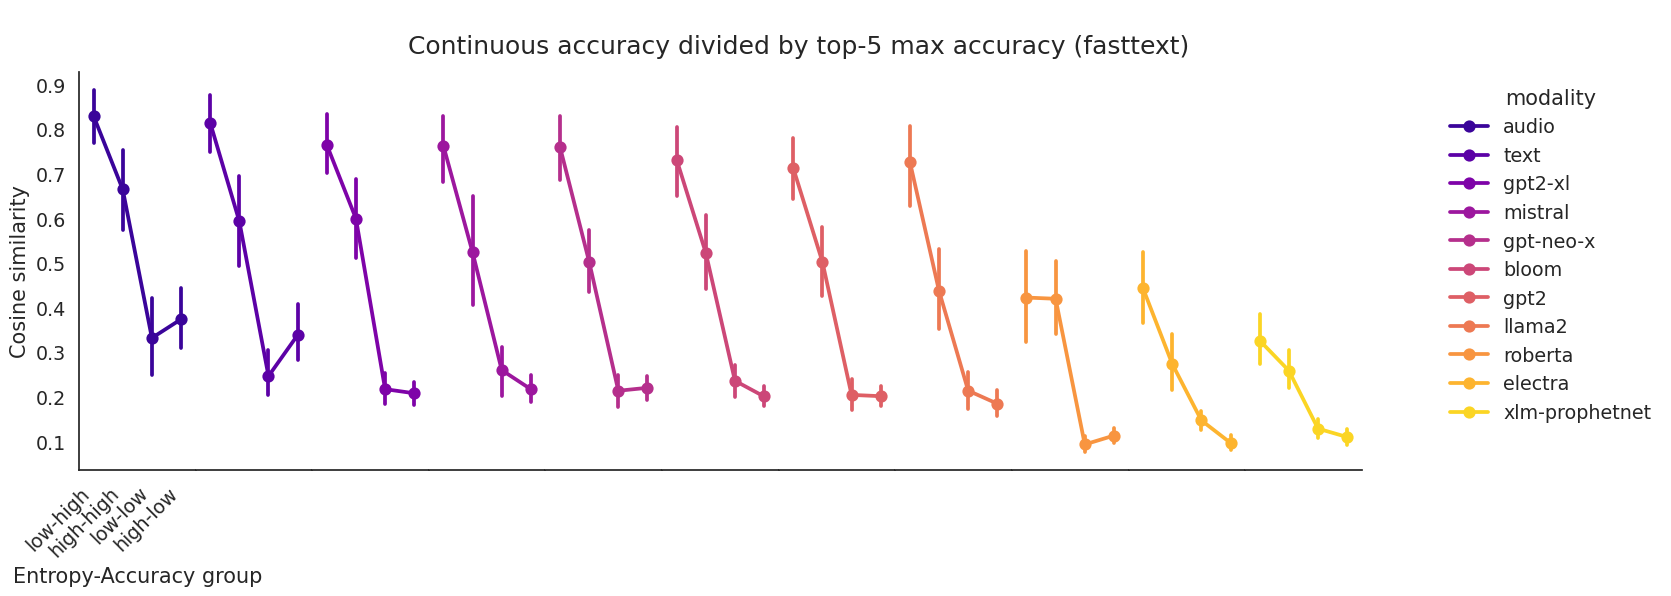

In [48]:
g = sns.catplot(
    data=human_model_combined, x="entropy_accuracy_group", y=f"{word_model_name}_avg_accuracy", col="modality",
    hue='modality', palette='plasma', kind="point", height=5, aspect=.25, 
    sharex=False, sharey=True, margin_titles=False, order=ordered_conditions, 
    col_order=ordered_modalities, hue_order=ordered_modalities
)

g.set_axis_labels("", "Cosine similarity")  # Optional: Set axis labels
g.set_titles(template="")
axes = g.axes.flat

# Despine all axes except the first
for i, ax in enumerate(axes):
    if i > 0:
        sns.despine(ax=ax, left=True)
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_xlabel("Entropy-Accuracy group")

# Share x-axis among subplots
g.fig.subplots_adjust(wspace=0)

# Move the legend to the upper left on the first subplot
legend = g._legend
legend.set_bbox_to_anchor((0.9, 1.05))
legend.set_loc("upper left")

plt.suptitle(f'Continuous accuracy divided by top-5 max accuracy ({word_model_name})')
plt.ylabel('Cosine similarity')

### Plot 06 - KL Divergence b/w model and human distributions

In [3]:
df_kl_div = []

for task in task_list:

    df = pd.read_csv(os.path.join(results_dir,  f'task-{task}_group-analyzed-behavior_human-model-distributions-lemmatized.csv'))
    df['task'] = task
    df_kl_div.append(df)

df_kl_div = pd.concat(df_kl_div).reset_index(drop=True)

(0.0, 10.0)

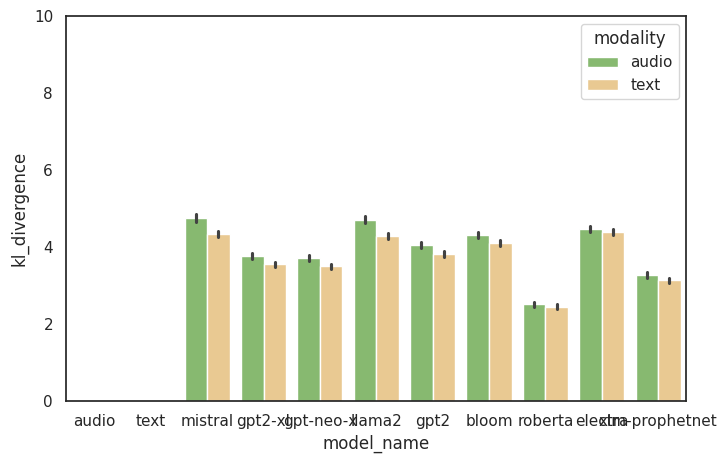

In [60]:
# cmap = create_spoken_written_cmap(continuous=False)
sns.set(style='white', rc={'figure.figsize':(8,5)})

variable = 'kl_divergence'

cmap = utils.create_spoken_written_cmap(continuous=False)

# sns.violinplot(y = df[df["Column"]<x]["Column"]) 
df_kl_div = df_kl_div[df_kl_div[variable] < 10]
sns.barplot(data=df_kl_div, x='model_name', y=variable, hue='modality', palette=cmap, order=ordered_modalities)
plt.ylim([0, 10])

## Plot human alignment with predictability

In [86]:
def log_odds(p):
    """
    Calculate the log odds (logit) of a probability or array of probabilities.
    
    The log odds is defined as log(p/(1-p)) where p is a probability.
    
    Parameters:
    -----------
    p : float or numpy.ndarray
        Probability value(s) between 0 and 1 inclusive
        
    Returns:
    --------
    float or numpy.ndarray
        Log odds value(s). Returns:
        - np.inf for p = 1
        - -np.inf for p = 0
        - np.nan for p < 0, p > 1, or p = nan
    
    Examples:
    --------
    >>> log_odds(0.5)
    0.0
    >>> log_odds(0.75)
    1.098612288668109
    >>> log_odds(1.0)
    inf
    >>> log_odds(0.0)
    -inf
    """
    
    # Convert input to numpy array for vectorized operations
    p_arr = np.asarray(p, dtype=float)
    
    # Initialize output array with NaN
    result = np.full_like(p_arr, np.nan)
    
    # Valid probability mask (0 ≤ p ≤ 1)
    valid_mask = (p_arr >= 0) & (p_arr <= 1)
    
    # Handle edge cases first
    result[p_arr == 1] = np.inf
    result[p_arr == 0] = -np.inf
    
    # Calculate log odds for valid probabilities (excluding 0 and 1)
    middle_mask = valid_mask & (p_arr != 0) & (p_arr != 1)
    result[middle_mask] = np.log(p_arr[middle_mask] / (1 - p_arr[middle_mask]))
    
    # If input was a scalar, return scalar
    return float(result) if np.isscalar(p) else result

In [118]:
import analysis_utils as utils
# from tommy_utils.statistics import log_odds

df_kl_div = []

for task in task_list:

    df = pd.read_csv(os.path.join(results_dir,  f'task-{task}_group-analyzed-behavior_human-model-distributions-lemmatized.csv'))
    df['task'] = task
    df_kl_div.append(df)

df_kl_div = pd.concat(df_kl_div).reset_index(drop=True)

df_kl_div['log_odds_predictability_model'] = df_kl_div['predictability_model'].apply(log_odds)
df_kl_div.loc[df_kl_div['log_odds_predictability_model'] < -25, 'log_odds_predictability_model'] = -25

df_kl_div['log_odds_predictability_human'] = df_kl_div['predictability_human'].apply(lambda x: log_odds(x) if x < 1 else 4)

# drop infinite values
drop_idxs = df_kl_div[np.isinf(df_kl_div['log_odds_predictability_human'])]['word_index'].unique()
df_kl_div = df_kl_div[~df_kl_div['word_index'].isin(drop_idxs)].reset_index(drop=True)



In [97]:
# get all MLM models except BERT
MLM_MODELS = list(nlp.MLM_MODELS_DICT.keys())[1:]
CLM_MODELS = list(nlp.CLM_MODELS_DICT.keys()) 
model_names = CLM_MODELS + MLM_MODELS

In [119]:
df_kl_div.loc[df_kl_div['model_name'].isin(CLM_MODELS), 'model_type'] = 'CLM'
df_kl_div.loc[df_kl_div['model_name'].isin(MLM_MODELS), 'model_type'] = 'MLM'

# df_kl_div = df_kl_div[df_kl_div['model_type'] == 'CLM']

In [120]:
df_kl_div.to_csv('test-log-odds.csv')

In [113]:
df_kl_div

,top_word_human,top_word_model,top_word_model_adjusted,prob_human,prob_model,prob_model_adjusted,prob_model_human_pred,predictability_model,predictability_human,continuous_predictability_human,...,wasserstein_dist,jensenshannon_dist,ks_stat,model_name,modality,word_index,entropy_group,accuracy_group,ground_truth,task
0,college,high,high,0.48,0.194395,0.015537,0.015537,1.722995e-05,0.48,0.722881,...,0.017203,0.778488,0.91,bloom,audio,6,low,high,college,black
1,interesting,exagger,exagger,0.10,0.112712,0.349688,0.000157,5.534143e-09,0.02,0.193742,...,0.006161,0.686587,0.67,bloom,audio,24,high,low,internship,black
2,weekend,weekends,weekends,0.46,0.090017,0.216046,0.006777,1.845969e-07,0.46,0.550719,...,0.009050,0.757841,0.81,bloom,audio,46,low,high,weekend,black
3,play,be,be,0.18,0.058938,0.044965,0.038922,1.691819e-06,0.18,0.358462,...,0.006034,0.710902,0.74,bloom,audio,49,high,high,play,black
4,week,time,time,0.72,0.389416,0.140392,0.004779,2.930560e-06,0.72,0.778846,...,0.013419,0.803380,0.89,bloom,audio,56,low,high,week,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7159,own,let,let,0.34,0.040039,0.029678,0.002897,6.738008e-03,0.26,0.465877,...,0.015832,0.759519,0.92,xlm-prophetnet,text,1913,low,high,live,howtodraw
7160,one,let,let,0.74,0.086683,0.048019,0.005174,4.239384e-03,0.74,0.854317,...,0.015119,0.776669,0.93,xlm-prophetnet,text,1916,low,high,one,howtodraw
7161,tear,the,the,0.28,0.192398,0.264955,0.001483,5.429776e-04,0.28,0.443715,...,0.007405,0.719833,0.80,xlm-prophetnet,text,1923,high,low,tear,howtodraw
7162,one,the,the,0.70,0.259477,0.086191,0.008378,1.261421e-02,0.70,0.778523,...,0.013903,0.787185,0.88,xlm-prophetnet,text,1926,low,high,one,howtodraw


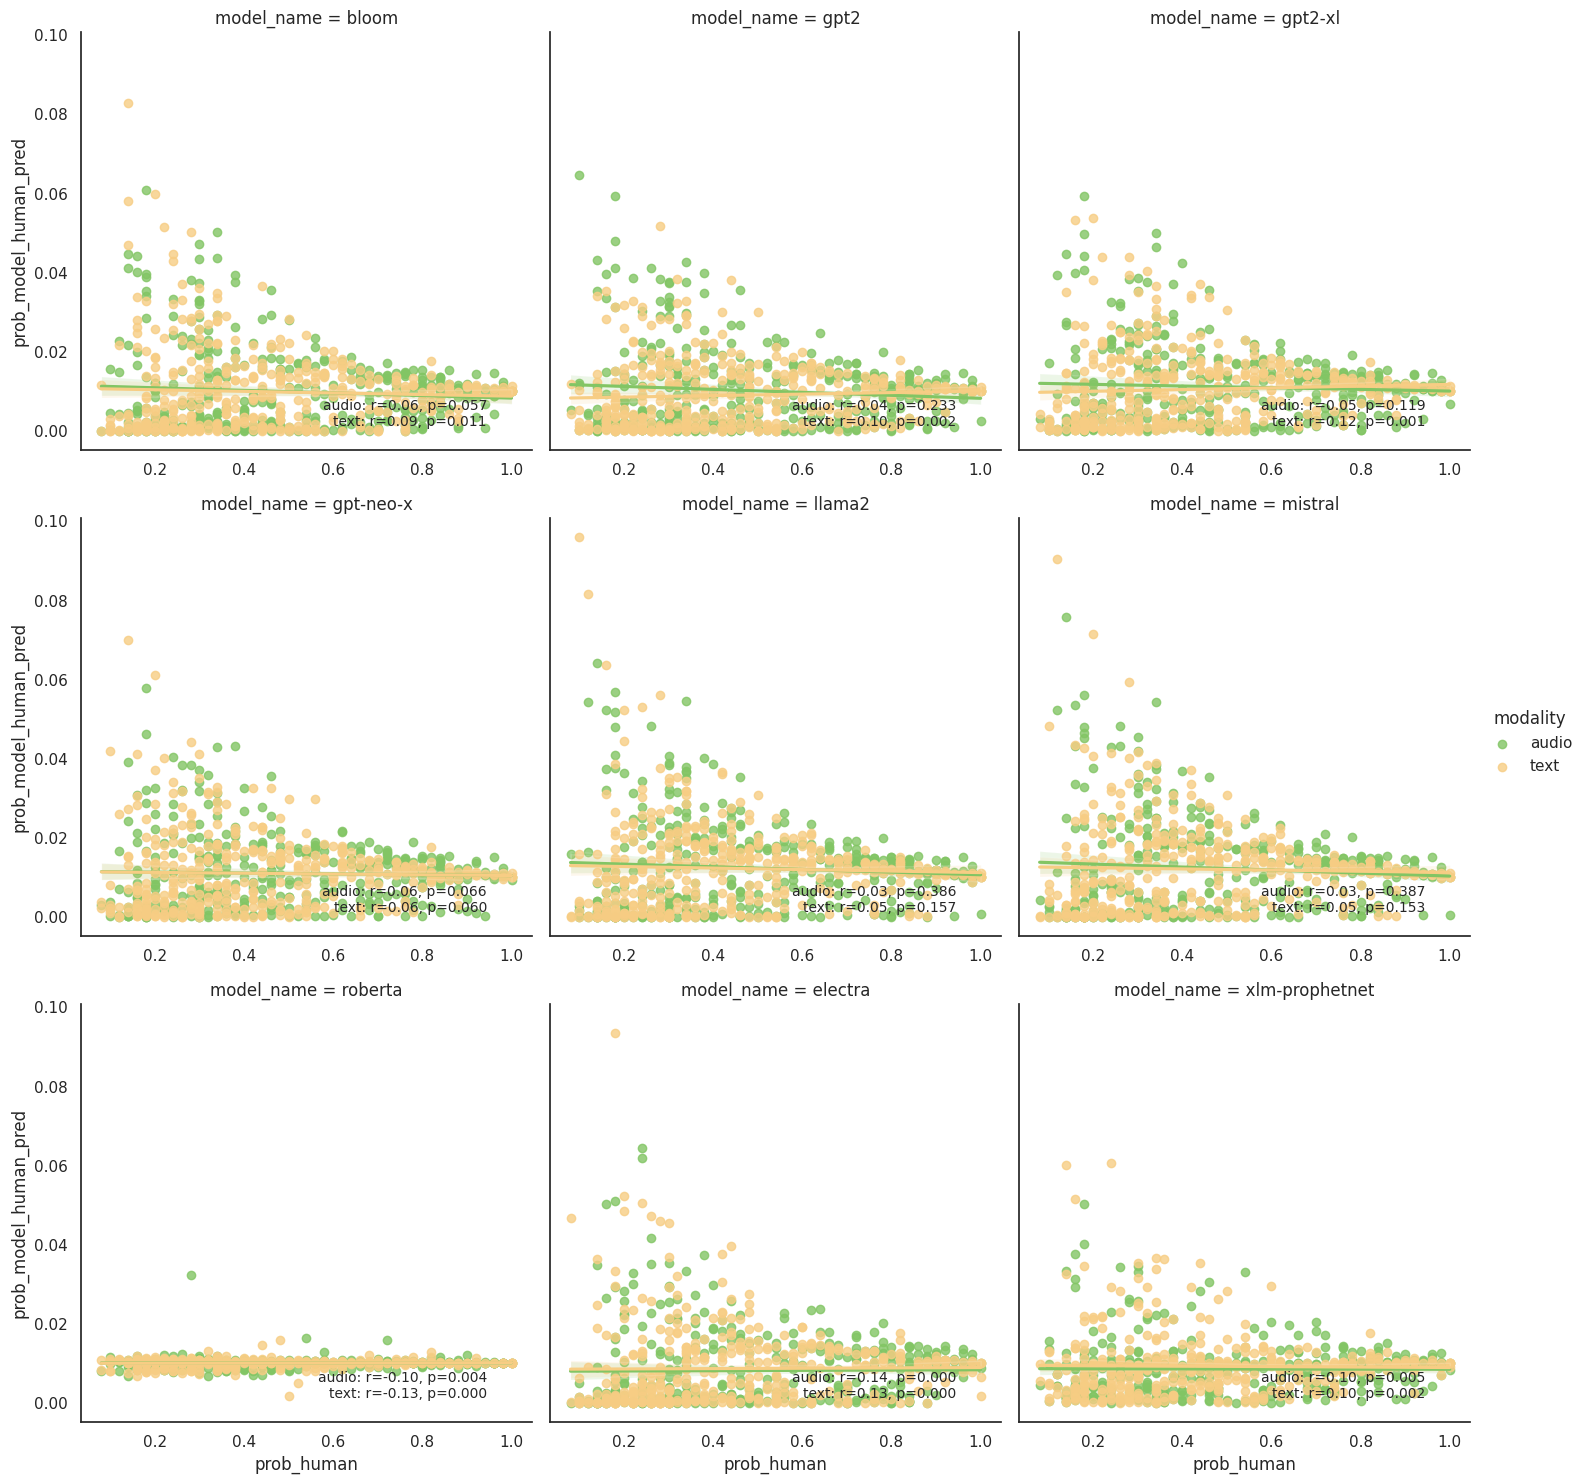

In [121]:
## Plot human 
import analysis_utils as utils

cmap = utils.create_spoken_written_cmap(continuous=False)

col = 'model_name'
hue = 'modality'
x = 'prob_human'
y = 'prob_model_human_pred' #'fasttext_top_word_accuracy'

model_names = df_kl_div[col].unique()

g = sns.lmplot(df_kl_div, 
           x=x, 
           y=y, 
           col=col,
           hue=hue,
           sharex=False,
           col_wrap=3,
           height=5, palette=cmap)

for i, model_name in enumerate(model_names):

    df = g.data[g.data[col] == model_name]
    ax = g.axes[i] 
    df = df.dropna()
    dfs = [d for _, d in df.groupby(hue)]
    rvals, pvals = zip(*[stats.kendalltau(df[x], df[y]) for df in dfs])
    
    ax.annotate(f'audio: r={rvals[0]:.2f}, p={pvals[0]:.3f}\ntext: r={rvals[1]:.2f}, p={pvals[1]:.3f}',
                       xy=(0.9, 0.05), xycoords=ax.transAxes,
                       ha='right', va='bottom', fontsize=10)
    
plt.show()